# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [204]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2014-11-19/data_eval_new/"
file_name = "int_norm_20141119_no_bgd.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [205]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [206]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [207]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/no_bgd_corr/df_bgd_corr',
 '/evaluation/no_bgd_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/no_bgd_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/no_bgd_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/no_bgd_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/no_bgd_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/no_bgd_corr/r_118_120/No_interference_corr/df_internal_norm',
 '/evaluation/n

# Plot raw data and check measurement

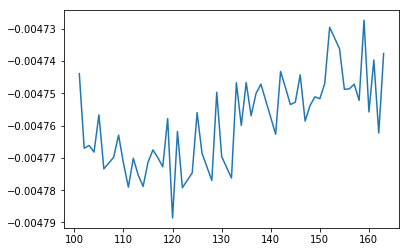

In [208]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

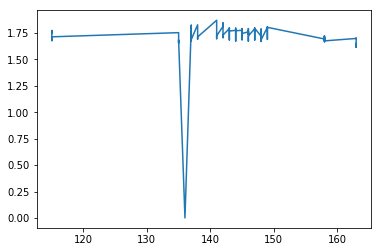

In [209]:
# Check Signals
column = "122"
sample = "SPEX 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [210]:
df_mean(signals[signals["118"] < 0.05])

,Filenumber,Sample,110,111,112,113,114,115,116,117,...,120_2,121_2,122_2,123_2,124_2,125_2,126_2,127_2,129_2,131_2
Date,,,,,,,,,,,,,,,,,,,,,
2014-11-19 17:41:00,102,blank sol,0.000866,0.001025,0.002024,0.000995,0.002416,0.000044,0.002243,0.000838,...,0.003817,0.003662,0.000560,0.002813,0.000823,0.000254,0.000760,0.024820,0.017317,0.014245
2014-11-19 18:05:00,104,blank sol,0.000556,0.000819,0.001627,0.000792,0.001926,0.000044,0.001659,0.000611,...,0.003341,0.004100,0.000501,0.003159,0.000737,0.000238,0.000708,0.024218,0.017468,0.014368
2014-11-19 18:27:00,106,blank sol,0.000777,0.001004,0.001947,0.000967,0.002334,0.000028,0.002071,0.000768,...,0.003426,0.004232,0.000496,0.003275,0.000741,0.000214,0.000647,0.023651,0.017129,0.014099
2014-11-19 18:50:00,108,blank sol,0.000564,0.000751,0.001474,0.000726,0.001739,0.000064,0.001457,0.000518,...,0.002753,0.004546,0.000412,0.003527,0.000586,0.000213,0.000626,0.023109,0.016421,0.013508
2014-11-19 19:13:00,110,blank sol,0.000542,0.000735,0.001417,0.000699,0.001691,0.000044,0.001616,0.000622,...,0.003101,0.004902,0.000427,0.003783,0.000645,0.000159,0.000541,0.022445,0.016402,0.013505
2014-11-19 19:35:00,112,blank sol,0.000409,0.000873,0.001712,0.000839,0.002044,0.000020,0.001877,0.000713,...,0.003290,0.004984,0.000446,0.003844,0.000674,0.000206,0.000565,0.021984,0.016481,0.013559
2014-11-19 19:58:00,114,blank sol,0.000569,0.000730,0.001440,0.000730,0.001721,0.000040,0.001659,0.000629,...,0.003036,0.005178,0.000404,0.003973,0.000596,0.000153,0.000444,0.021382,0.015880,0.013182
2014-11-19 20:21:00,116,blank sol,0.000499,0.000719,0.001398,0.000692,0.001691,0.000028,0.001506,0.000575,...,0.003194,0.005565,0.000441,0.004287,0.000643,0.000143,0.000450,0.021265,0.016029,0.013174
2014-11-19 20:43:00,118,blank sol,0.000699,0.000741,0.001529,0.000710,0.001791,0.000052,0.002794,0.001244,...,0.005905,0.000151,0.000818,0.000127,0.001155,0.000153,0.000475,0.021201,0.016567,0.013635


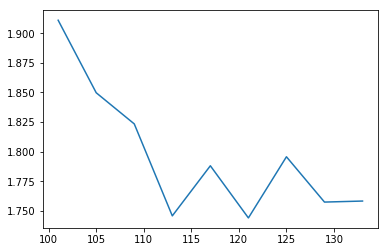

In [211]:
# Check Signals - mean
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

In [212]:
# Check background 
column = "118"
sample = "NIST 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

KeyError: 'No object named /evaluation/bgd_outlier_corr/df_bgd_corr in the file'

In [213]:
background_mean = df_mean(background)

# Outlier rejection

In [243]:
bgd_method = 'no_bgd_corr' #'no_bgd_corr'
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [244]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [245]:
column = "124/118"
sample = "NIST 100ppb"

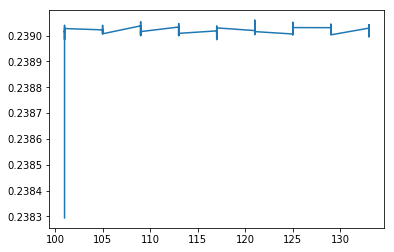

In [246]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [247]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [248]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2014-11-19 17:29:00,NIST 100ppb,2,1,101,NaN,0.027288,NaN,NaN,NaN,NaN,NaN,0.19125,NaN
2014-11-19 17:29:00,NIST 100ppb,2,2,101,0.040172,0.027208,0.013941,0.600324,0.316685,0.354583,1.346011,NaN,0.239017
2014-11-19 17:29:00,NIST 100ppb,2,3,101,0.040235,0.027265,0.013941,0.600355,0.316690,0.354585,1.346007,0.19125,0.239015
2014-11-19 17:29:00,NIST 100ppb,2,4,101,0.040220,0.027266,0.013941,0.600328,0.316687,0.354587,1.346024,0.19125,0.239013
2014-11-19 17:29:00,NIST 100ppb,2,5,101,0.040092,0.027155,0.013944,0.600334,0.316676,0.354584,1.345996,0.19125,0.239039
2014-11-19 17:29:00,NIST 100ppb,2,6,101,0.040150,0.027182,0.013942,0.600316,0.316705,0.354573,1.345997,0.19125,0.239007
2014-11-19 17:29:00,NIST 100ppb,2,7,101,0.040152,0.027185,NaN,0.600322,0.316712,0.354573,1.346015,0.19125,0.238986
2014-11-19 17:29:00,NIST 100ppb,2,8,101,0.040150,0.027149,0.013937,0.600321,0.316695,0.354589,1.346046,0.19125,0.239026
2014-11-19 17:29:00,NIST 100ppb,2,9,101,0.040222,0.027231,0.013941,0.600295,0.316696,0.354583,1.346008,0.19125,0.239021


In [249]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
103         2014-11-19 17:52:00    0.257935
            2014-11-19 17:52:00    0.258228
125         2014-11-19 22:02:00    0.259119
135         2014-11-19 23:55:00    0.259386
137         2014-11-20 00:19:00    0.259809
138         2014-11-20 00:31:00    0.259074
147         2014-11-20 02:45:00    0.259277
150         2014-11-20 03:41:00    0.259008
152         2014-11-20 04:05:00    0.258833
            2014-11-20 04:05:00    0.258691
156         2014-11-20 04:54:00    0.259771
158         2014-11-20 05:18:00    0.258688
163         2014-11-20 06:18:00    0.258652
Name: 124/118, dtype: float64

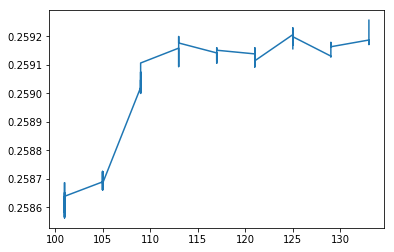

In [250]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [251]:
df[df["Sample"] == sample][column].std()

0.00021473822546268557

In [252]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

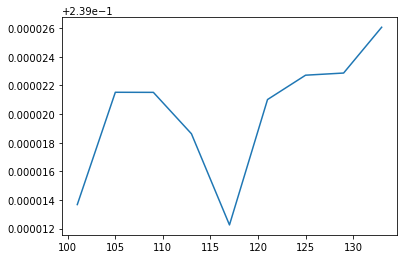

In [253]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [254]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2014-11-19 17:29:00,101,NIST 100ppb,0.040167,0.027204,0.013942,0.600336,0.316693,0.354582,1.346029,0.19125,0.239014
2014-11-19 17:52:00,103,SPEX 10ppb,0.040161,0.027193,0.013946,0.600347,0.316711,0.354595,1.346450,0.19125,0.239006
2014-11-19 18:15:00,105,NIST 100ppb,0.040161,0.027193,0.013944,0.600323,0.316700,0.354588,1.346059,0.19125,0.239022
2014-11-19 19:01:00,109,NIST 100ppb,0.040170,0.027200,0.013945,0.600349,0.316700,0.354580,1.346050,0.19125,0.239022
2014-11-19 19:24:00,111,SPEX 50ppb,0.040191,0.027217,0.013956,0.600364,0.316702,0.354583,1.346118,0.19125,0.239017
2014-11-19 19:46:00,113,NIST 100ppb,0.040166,0.027199,0.013948,0.600360,0.316702,0.354579,1.346039,0.19125,0.239019
2014-11-19 20:09:00,115,SPEX 100ppb,0.040167,0.027197,0.013957,0.600351,0.316697,0.354575,1.346055,0.19125,0.239017
2014-11-19 20:31:00,117,NIST 100ppb,0.040157,0.027188,0.013948,0.600354,0.316703,0.354581,1.346040,0.19125,0.239012
2014-11-19 20:54:00,119,SPEX 200ppb,0.040156,0.027189,0.013956,0.600331,0.316694,0.354577,1.346043,0.19125,0.239018


In [255]:
date_list = [pd.Timestamp("2014-11-20 00:07:00")]
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [256]:
drop_sum = []

In [257]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [258]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [259]:
data_mean_int_sum

112/118                   114/118                   115/118  \
                 mean       SD2 count      mean       SD2 count      mean   
Sample                                                                      
NIST 100ppb  0.040162  0.000010     9  0.027194  0.000012     9  0.013946   
SPEX 100ppb  0.040156  0.000010    15  0.027187  0.000008    15  0.013956   
SPEX 10ppb   0.040145  0.000057     4  0.027177  0.000059     4  0.013948   
SPEX 200ppb  0.040155  0.000003     3  0.027186  0.000005     3  0.013956   
SPEX 20ppb   0.040147  0.000064     3  0.027176  0.000049     3  0.013942   
SPEX 50ppb   0.040155  0.000050     4  0.027188  0.000041     4  0.013957   

                              116/118  ...  119/118   120/118                  \
                  SD2 count      mean  ...    count      mean       SD2 count   
Sample                                 ...                                      
NIST 100ppb  0.000005     9  0.600346  ...        9  1.346048  0.000021     9   
SPEX 100ppb  0.000002    15  0.600338  ...       15  1.346056  0.000012    15   
SPEX 10ppb   0.000019     4  0.600353  ...        4  1.346564  0.000155     4   
SPEX 200ppb  0.000001     3  0.600330  ...        3  1.346038  0.000013     3   
SPEX 20ppb   0.000010     3  0.600349  ...        3  1.346291  0.000047     3   
SPEX 50ppb   0.000003     4  0.600342  ...        4  1.346114  0.000026     4   

             122/118                       124/118                  
                mean           SD2 count      mean       SD2 count  
Sample                                                              
NIST 100ppb  0.19125  7.076311e-17     9  0.239020  0.000009     9  
SPEX 100ppb  0.19125  1.027867e-16    15  0.239021  0.000006    15  
SPEX 10ppb   0.19125  7.166459e-17     4  0.239025  0.000028     4  
SPEX 200ppb  0.19125  8.777084e-17     3  0.239021  0.000005     3  
SPEX 20ppb   0.19125  8.777084e-17     3  0.239020  0.000018     3  
SPEX 50ppb   0.19125  9.614813e-17     4  0.239022  0.000007     4  

[6 rows x 27 columns]

In [260]:
date_list = []


epsilon_int_NIST = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)
epsilon_int_SPEX = SSB(data_mean_int.drop(date_list), "SPEX 100ppb", 10000)
delta_raw_SPEX = SSB(data_mean_raw.drop(date_list), "SPEX 100ppb", 1000)

In [261]:
epsilon_int_NIST

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2014-11-19 17:29:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NIST 100ppb
2014-11-19 17:52:00,0.0,-0.734331,-2.086950,1.998069,0.291498,0.456411,0.278453,3.017497,0.000000e+00,-0.485128,SPEX 10ppb
2014-11-19 18:15:00,0.0,-1.859337,-3.593994,0.086001,-0.332937,0.114670,0.200424,0.143919,-1.110223e-12,0.164158,NIST 100ppb
2014-11-19 19:01:00,0.0,1.625975,1.739541,-0.676193,0.131578,-0.045237,-0.088991,0.010799,0.000000e+00,0.060338,NIST 100ppb
2014-11-19 19:24:00,0.0,5.854818,6.406063,6.691096,0.144473,0.027762,0.089834,0.548589,-1.110223e-12,-0.118344,SPEX 50ppb
2014-11-19 19:46:00,0.0,0.532633,1.575699,1.234392,0.143335,0.024221,-0.053309,-0.048732,0.000000e+00,0.072676,NIST 100ppb
2014-11-19 20:09:00,0.0,1.314905,1.116764,6.085581,-0.095872,-0.181336,-0.153267,0.111201,2.220446e-12,0.078377,SPEX 100ppb
2014-11-19 20:31:00,0.0,-1.881286,-2.400765,-0.200095,-0.039654,0.092870,0.024271,-0.069263,-4.440892e-12,-0.316255,NIST 100ppb
2014-11-19 20:54:00,0.0,-1.056214,-0.462574,5.399621,-0.373187,-0.211851,-0.129496,-0.057280,0.000000e+00,0.067715,SPEX 200ppb


In [262]:

date_list = []

epsilon_int_NIST = epsilon_int_NIST.drop(date_list)
delta_raw_NIST = delta_raw_NIST.drop(date_list)

In [263]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -1000) & (df["Filenumber"] <= 1000)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [264]:
epsilon_int_NIST = epsilon_process(epsilon_int_NIST)
delta_raw_NIST = epsilon_process(delta_raw_NIST)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [265]:
epsilon_int_NIST

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2014-11-19 17:52:00,103,-0.734331,-2.086950,1.998069,0.291498,0.456411,0.278453,3.017497,0.000000e+00,-0.485128,SPEX 10ppb
2014-11-19 18:15:00,105,-1.859337,-3.593994,0.086001,-0.332937,0.114670,0.200424,0.143919,-1.110223e-12,0.164158,NIST 100ppb
2014-11-19 19:01:00,109,1.625975,1.739541,-0.676193,0.131578,-0.045237,-0.088991,0.010799,0.000000e+00,0.060338,NIST 100ppb
2014-11-19 19:24:00,111,5.854818,6.406063,6.691096,0.144473,0.027762,0.089834,0.548589,-1.110223e-12,-0.118344,SPEX 50ppb
2014-11-19 19:46:00,113,0.532633,1.575699,1.234392,0.143335,0.024221,-0.053309,-0.048732,0.000000e+00,0.072676,NIST 100ppb
2014-11-19 20:09:00,115,1.314905,1.116764,6.085581,-0.095872,-0.181336,-0.153267,0.111201,2.220446e-12,0.078377,SPEX 100ppb
2014-11-19 20:31:00,117,-1.881286,-2.400765,-0.200095,-0.039654,0.092870,0.024271,-0.069263,-4.440892e-12,-0.316255,NIST 100ppb
2014-11-19 20:54:00,119,-1.056214,-0.462574,5.399621,-0.373187,-0.211851,-0.129496,-0.057280,0.000000e+00,0.067715,SPEX 200ppb
2014-11-19 21:17:00,121,0.966950,0.082905,0.018622,-0.016102,-0.097541,0.046401,0.125537,4.440892e-12,0.147539,NIST 100ppb


In [266]:
epsilon_NIST_sum = np.round(epsilon_int_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_sum = np.round(delta_raw_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_SPEX_sum = np.round(epsilon_int_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_SPEX_sum = np.round(delta_raw_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_sum .append(epsilon_SPEX_sum)
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_sum.append(delta_raw_SPEX_sum)
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [2]:
epsilon_sum_all

NameError: name 'epsilon_sum_all' is not defined

In [531]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST.append(epsilon_int_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST.append(delta_raw_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [532]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [198]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [199]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
#background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [268]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [269]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST.append(epsilon_int_SPEX).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST.append(delta_raw_SPEX).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [270]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [271]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')